In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from plotly.subplots import make_subplots  #載入plotly畫子圖的套件
import movingAverage as ma
import mplfinance as mpf
import plotly.graph_objs as go

# 一、資料前處理: 台指期

In [3]:
# 獲取台指期交易數據
TXF = pd.read_csv("C:/Users/jack/Desktop/程式/Python/Python_策略分析/2020~2023台指期.csv",sep = "\t")

TXF = TXF["Date,Close,Open,High,Low,Volumn,SettlementPrice,Spread"].str.split(",", expand = True)

# 設定新的欄位名稱
TXF.columns = ["Date", "Close", "Open", "High", "Low", "Volume", "SettlementPrice", "Spread"]

# 將所有的逗號去掉
TXF = TXF.apply(lambda x: x.str.replace(",", ""))

# 將數值欄位轉換成浮點數
numeric_cols = ["Close", "Open", "High", "Low", "Volume", "SettlementPrice", "Spread"]
TXF[numeric_cols] = TXF[numeric_cols].astype(float)
TXF.index = pd.to_datetime(TXF["Date"])
TXF

Date    Close     Open     High      Low    Volume  \
Date                                                                   
2020-01-02    2020/1/2  12102.0  12044.0  12120.0  12023.0  100401.0   
2020-01-03    2020/1/3  12086.0  12180.0  12198.0  11996.0  172660.0   
2020-01-06    2020/1/6  11950.0  12017.0  12034.0  11948.0  118380.0   
2020-01-07    2020/1/7  11871.0  11995.0  12009.0  11816.0  157264.0   
2020-01-08    2020/1/8  11788.0  11728.0  11892.0  11697.0  158971.0   
...                ...      ...      ...      ...      ...       ...   
2023-10-13  2023/10/13  16770.0  16750.0  16807.0  16730.0   67885.0   
2023-10-16  2023/10/16  16648.0  16661.0  16683.0  16603.0  101143.0   
2023-10-17  2023/10/17  16650.0  16764.0  16782.0  16634.0   82744.0   
2023-10-18  2023/10/18  16468.0  16642.0  16649.0  16454.0   61156.0   
2023-10-19  2023/10/19  16458.0  16365.0  16487.0  16357.0   83646.0   

            SettlementPrice  Spread  
Date                                 
2020-01-02          12101.0   108.0  
2020-01-03          12087.0   -15.0  
2020-01-06          11949.0  -137.0  
2020-01-07          11871.0   -78.0  
2020-01-08          11788.0   -83.0  
...                     ...     ...  
2023-10-13          16771.0   -78.0  
2023-10-16          16649.0  -123.0  
2023-10-17          16650.0     1.0  
2023-10-18          16468.0  -206.0  
2023-10-19          16461.0   -10.0  

[923 rows x 8 columns]

In [4]:
# 提取開盤、收盤、最高、最低數據
Close = TXF.Close
High = TXF.High
Low = TXF.Low
Open = TXF.Open

In [5]:
Close.head(5)

Date
2020-01-02    12102.0
2020-01-03    12086.0
2020-01-06    11950.0
2020-01-07    11871.0
2020-01-08    11788.0
Name: Close, dtype: float64

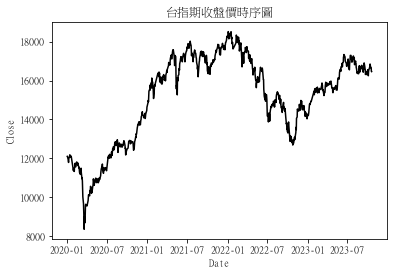

In [7]:
# 繪製收盤價數據時序圖
plt.plot(Close,"k")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("台指期收盤價時序圖")
plt.rcParams["font.family"] = "MingLiU"    
plt.rcParams["axes.unicode_minus"] = False

In [8]:
Close.describe()

count      923.000000
mean     15107.099675
std       2246.009741
min       8353.000000
25%      13294.000000
50%      15692.000000
75%      16933.500000
max      18516.000000
Name: Close, dtype: float64

## 主策略: 雙均線交叉捕捉買賣點

In [9]:
# 定義 moving Average 函數
def smaCal(tsPrice,k):
    sma=pd.Series([np.nan]*len(tsPrice),index=tsPrice.index)
    for i in range(k-1,len(tsPrice)):
        sma[i]=np.mean(tsPrice[(i-k+1):(i+1)])
    return(sma)

def smaCal_gene(price,k):
    #priceList只存需要計算的k期股價數據
    #用first in first out的方式來存刪數據，進而體現移動的思想
    priceList=[]
    n = len(price)
    for i in range(n):
        #在priceList中增加最新一筆數據
        priceList.append(price[i])
        if len(priceList)==k:
            yield np.mean(priceList)
            #刪除priceList中第0期數據
            priceList.pop(0)

In [10]:
# short  and  long
# 分別產生5日&20日sma的產生器

sma5_gene = ma.smaCal_gene(Close,5)
sma20_gene = ma.smaCal_gene(Close,20)

In [11]:
# 尋找買賣交易信號，並制定交易執行日期

sma5_before = next(sma5_gene)
sma20_before = next(sma20_gene)
SLSignal=[]
for i in range(21,len(Close)):
    sma5_now = next(sma5_gene)
    sma20_now = next(sma20_gene)
    if sma5_before < sma20_before and sma5_now > sma20_now:           # 當短期均線”由下往上穿越”長期均線 => 產生”買入訊號”
        SLSignal.append(1)
    elif sma5_before > sma20_before and sma5_now < sma20_now:         # 當短期均線”由上往下穿越”長期均線 => 產生”賣出訊號”
        SLSignal.append(-1)
    else:
        SLSignal.append(0)
    sma5_before = sma5_now
    sma20_before = sma20_now

SLSignal = pd.Series(SLSignal, index = Close.index[21:])

In [12]:
SLSignal

Date
2020-02-11    0
2020-02-12    0
2020-02-13    0
2020-02-14    0
2020-02-17    0
             ..
2023-10-13    0
2023-10-16    0
2023-10-17    0
2023-10-18    0
2023-10-19   -1
Length: 902, dtype: int64

In [13]:
SLSignal[SLSignal==1]

Date
2020-03-04    1
2020-07-06    1
2020-09-01    1
2020-09-21    1
2020-09-25    1
2020-11-04    1
2021-02-24    1
2021-03-16    1
2021-05-13    1
2021-07-28    1
2021-09-28    1
2021-12-10    1
2022-01-26    1
2022-03-07    1
2022-04-18    1
2022-06-22    1
2022-09-06    1
2022-12-22    1
2023-03-10    1
2023-03-28    1
2023-04-26    1
2023-07-10    1
2023-08-09    1
2023-09-25    1
dtype: int64

In [14]:
SLSignal[SLSignal==-1]

Date
2020-02-25   -1
2020-04-14   -1
2020-07-08   -1
2020-09-15   -1
2020-09-22   -1
2020-10-21   -1
2020-11-12   -1
2021-02-26   -1
2021-03-29   -1
2021-06-07   -1
2021-09-08   -1
2021-10-28   -1
2021-12-20   -1
2022-02-25   -1
2022-03-31   -1
2022-06-06   -1
2022-07-27   -1
2022-11-11   -1
2023-01-16   -1
2023-03-13   -1
2023-04-10   -1
2023-05-19   -1
2023-07-20   -1
2023-09-07   -1
2023-10-19   -1
dtype: int64

# 二、交易策略建構 =>  主交易邏輯: 交叉均線策略； 濾網: RSI

## 1. 濾網的建構

### 超買、超賣 ( 以下以股票為例 )
#### RSI>70: 股票會出現超買信號，股票買入力道過大，買入力道在未來可能會減小，股票未來價格可能會下跌 
#### => 避免超買，必須RSI<70 (賣出訊號)
#### RSI<30: 股票會出現超賣信號，股票賣出力道過大，賣出力道在未來會回到正常，股票未來價格可能會上漲 
#### => 避免超賣，必須RSI>30 (買入訊號)

In [15]:
# 定義 RSI 函數
def rsi(price,period=6):
    import pandas as pd
    closeDif = (price-price.shift(1)).dropna()
    upPrc = pd.Series(0, index = closeDif.index)
    upPrc[closeDif > 0] = closeDif[closeDif > 0]
    downPrc = pd.Series(0, index = closeDif.index)
    downPrc[closeDif < 0] = -closeDif[closeDif < 0]
    rsi=[]
    for i in range(period, len(upPrc)+1):
        up_mean = np.mean(upPrc.values[(i-period):i], dtype=np.float32)
        up_down = np.mean(downPrc.values[(i-period):i], dtype=np.float32)
        rsi.append(100*up_mean/(up_mean+up_down))
    rsi = pd.Series(rsi, index = closeDif.index[(period-1):])
    return(rsi)

In [16]:
# RSI > 30（避免超賣） => 買入訊號 (+1)
# RSI < 70（避免超買） => 賣出訊號 (-1)
Rsi6 = rsi(Close,6)

Sig3=[]
for i in Rsi6:
    if i > 30:
        Sig3.append(1)
    elif i < 70:
        Sig3.append(-1)
    else:
        Sig3.append(0)

date3 = Rsi6.index
Signal3 = pd.Series(Sig3, index = date3)

In [17]:
Signal3

Date
2020-01-10    1
2020-01-13    1
2020-01-14    1
2020-01-15    1
2020-01-16    1
             ..
2023-10-13    1
2023-10-16    1
2023-10-17    1
2023-10-18    1
2023-10-19   -1
Length: 917, dtype: int64

## 2.創建交叉均線訊號與RSI訊號

In [18]:
# 當短期均線由下向上穿越長期均線，且同時RSI > 30（避免超賣） =>  InterSig1
# 當短期均線由上向下穿越長期均線，且同時RSI < 70（避免超買） =>  InterSig_1 

InterSig1 = Signal3[Signal3 == 1].index.intersection(SLSignal[SLSignal == 1].index)
InterSig_1 = Signal3[Signal3 == -1].index.intersection(SLSignal[SLSignal == -1].index)

In [19]:
InterSig1

DatetimeIndex(['2020-03-04', '2020-07-06', '2020-09-01', '2020-09-21',
               '2020-11-04', '2021-02-24', '2021-03-16', '2021-09-28',
               '2021-12-10', '2022-03-07', '2022-09-06', '2023-03-10',
               '2023-03-28', '2023-07-10', '2023-08-09'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [20]:
InterSig_1

DatetimeIndex(['2020-02-25', '2020-09-22', '2021-02-26', '2022-02-25',
               '2023-10-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [21]:
# 創建 InterSig 列表長度等同於 SLSignal, 並將Date 對應的 values 改成全部是 0

InterSig = SLSignal 
InterSig[:] = 0

# 你想要修改的日期列表
dates_to_change1 = ['2020-03-04', '2020-07-06', '2020-09-01', '2020-09-21',
                     '2020-11-04', '2021-02-24', '2021-03-16', '2021-09-28',
                     '2021-12-10', '2022-03-07', '2022-09-06', '2023-03-10',
                     '2023-03-28', '2023-07-10', '2023-08-09']
dates_to_change_1 = ['2020-02-25', '2020-09-22', '2021-02-26', '2022-02-25', '2023-10-19']  

for date in dates_to_change1:
    InterSig.loc[date] = 1

for date in dates_to_change_1:
    InterSig.loc[date] = -1

In [22]:
InterSig

Date
2020-02-11    0
2020-02-12    0
2020-02-13    0
2020-02-14    0
2020-02-17    0
             ..
2023-10-13    0
2023-10-16    0
2023-10-17    0
2023-10-18    0
2023-10-19   -1
Length: 902, dtype: int64

In [23]:
InterSig[InterSig == 1]

Date
2020-03-04    1
2020-07-06    1
2020-09-01    1
2020-09-21    1
2020-11-04    1
2021-02-24    1
2021-03-16    1
2021-09-28    1
2021-12-10    1
2022-03-07    1
2022-09-06    1
2023-03-10    1
2023-03-28    1
2023-07-10    1
2023-08-09    1
dtype: int64

In [24]:
InterSig[InterSig == -1]

Date
2020-02-25   -1
2020-09-22   -1
2021-02-26   -1
2022-02-25   -1
2023-10-19   -1
dtype: int64

In [25]:
InterTrade = InterSig.shift(1)

# 計算指數上升的預測準確率 
txfRet = Close/Close.shift(1)-1
Long_Inter = pd.Series(0, index = InterTrade.index)
Long_Inter[InterTrade == 1] = 1
LongRet_Inter = (Long_Inter*txfRet).dropna()
winLrate_Inter = len(LongRet_Inter[LongRet_Inter>0])/len(LongRet_Inter[LongRet_Inter!= 0] )
winLrate_Inter

0.42857142857142855

In [26]:
# 計算指數下跌的預測準確率 
Short_Inter = pd.Series(0, index = InterTrade.index)
Short_Inter[InterTrade == -1] = -1
ShortRet_Inter = (Short_Inter*txfRet).dropna()
winSrate_Inter = len(ShortRet_Inter[ShortRet_Inter>0])/len(ShortRet_Inter[ShortRet_Inter!=0])
winSrate_Inter

0.5

In [27]:
# 計算指數變化趨勢的預測獲勝率
SLtradeRet_Inter = (InterTrade*txfRet).dropna()
winRate_Inter = len(SLtradeRet_Inter[SLtradeRet_Inter>0])/len(SLtradeRet_Inter[SLtradeRet_Inter!=0])
winRate_Inter

0.4444444444444444

## 3.台指週選交易策略

In [28]:
# 讀檔
atm_df = pd.read_csv('C:/Users/jack/Desktop/政大/修課/必修/選擇權-評價與應用/pcr策略程式範例/atm_option_settle.csv')    # 價平附近履約價的選擇權收盤價
settledate_df  = pd.read_csv('C:/Users/jack/Desktop/政大/修課/必修/選擇權-評價與應用/pcr策略程式範例/settle_dates.csv') # 選擇權結算日即結算合約

# 轉換日期格式
atm_df['日期'] =pd.to_datetime(atm_df['日期'])
settledate_df['最後結算日'] =pd.to_datetime(settledate_df['最後結算日'])

In [29]:
# InterSig 訊號為 2020-02-11 ~ 2023-10-19 => 擷取atm_df從2020-02-11開始的資料
atmsubset_df = atm_df.iloc[21:]
atmsubset_df = atmsubset_df.reset_index(drop=True)

atmsubset_df

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價
0   2020-02-11          NaN        187.0          NaN          8.4
1   2020-02-12        110.0        293.0         90.0          0.2
2   2020-02-13          NaN        105.0          NaN         79.0
3   2020-02-14          NaN        108.0          NaN         47.0
4   2020-02-17          NaN         61.0          NaN         40.5
..         ...          ...          ...          ...          ...
865 2023-08-25          NaN        167.0          NaN         67.0
866 2023-08-28          NaN        182.0          NaN         23.5
867 2023-08-29          NaN        291.0          NaN          1.3
868 2023-08-30        133.0        381.0         98.0          0.1
869 2023-08-31          NaN         82.0          NaN        131.0

[870 rows x 5 columns]

In [30]:
# 初始化交易成本(點數)
trading_cost = 3

# 初始化第一天選擇權報酬
atmsubset_df.loc[0,"價平買權近週報酬"] = 0
atmsubset_df.loc[0,"價平賣權近週報酬"] = 0

# 計算選擇權報酬
for i in range(1, len(atmsubset_df)):
    yesdate = atmsubset_df.loc[i-1,"日期"]  # 昨日日期
    
    # 開始計算
    if yesdate in list(settledate_df["最後結算日"]):  # 在settledate_df["最後結算日"]中的第一個column日期
        # 若前一天是結算日，報酬用今日的價平近週每日結算價與昨日的價平次週每日結算價
        atmsubset_df.loc[i,"價平買權近週報酬"] = float(atmsubset_df.loc[i,"價平買權近週每日結算價"]) - float(atmsubset_df.loc[i-1,"價平買權次週每日結算價"]) - trading_cost
        atmsubset_df.loc[i,"價平賣權近週報酬"] = float(atmsubset_df.loc[i,"價平賣權近週每日結算價"]) - float(atmsubset_df.loc[i-1,"價平賣權次週每日結算價"]) - trading_cost
    else:
        # 若是平日，報酬用今日的價平近週每日結算價與昨日的價平近週每日結算價
        atmsubset_df.loc[i,"價平買權近週報酬"] = float(atmsubset_df.loc[i,"價平買權近週每日結算價"]) - float(atmsubset_df.loc[i-1,"價平買權近週每日結算價"]) 
        atmsubset_df.loc[i,"價平賣權近週報酬"] = float(atmsubset_df.loc[i,"價平賣權近週每日結算價"]) - float(atmsubset_df.loc[i-1,"價平賣權近週每日結算價"]) 

atmsubset_df

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
0   2020-02-11          NaN        187.0          NaN          8.4       0.0   
1   2020-02-12        110.0        293.0         90.0          0.2     106.0   
2   2020-02-13          NaN        105.0          NaN         79.0      -8.0   
3   2020-02-14          NaN        108.0          NaN         47.0       3.0   
4   2020-02-17          NaN         61.0          NaN         40.5     -47.0   
..         ...          ...          ...          ...          ...       ...   
865 2023-08-25          NaN        167.0          NaN         67.0    -266.0   
866 2023-08-28          NaN        182.0          NaN         23.5      15.0   
867 2023-08-29          NaN        291.0          NaN          1.3     109.0   
868 2023-08-30        133.0        381.0         98.0          0.1      90.0   
869 2023-08-31          NaN         82.0          NaN        131.0     -54.0   

     價平賣權近週報酬  
0         0.0  
1        -8.2  
2       -14.0  
3       -32.0  
4        -6.5  
..        ...  
865      54.5  
866     -43.5  
867     -22.2  
868      -1.2  
869      30.0  

[870 rows x 7 columns]

In [31]:
# 計算報酬的金額
atmsubset_df["價平買權近週報酬(金額)"] = atmsubset_df["價平買權近週報酬"]*50
atmsubset_df["價平賣權近週報酬(金額)"] = atmsubset_df["價平賣權近週報酬"]*50
atmsubset_df

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
0   2020-02-11          NaN        187.0          NaN          8.4       0.0   
1   2020-02-12        110.0        293.0         90.0          0.2     106.0   
2   2020-02-13          NaN        105.0          NaN         79.0      -8.0   
3   2020-02-14          NaN        108.0          NaN         47.0       3.0   
4   2020-02-17          NaN         61.0          NaN         40.5     -47.0   
..         ...          ...          ...          ...          ...       ...   
865 2023-08-25          NaN        167.0          NaN         67.0    -266.0   
866 2023-08-28          NaN        182.0          NaN         23.5      15.0   
867 2023-08-29          NaN        291.0          NaN          1.3     109.0   
868 2023-08-30        133.0        381.0         98.0          0.1      90.0   
869 2023-08-31          NaN         82.0          NaN        131.0     -54.0   

     價平賣權近週報酬  價平買權近週報酬(金額)  價平賣權近週報酬(金額)  
0         0.0           0.0           0.0  
1        -8.2        5300.0        -410.0  
2       -14.0        -400.0        -700.0  
3       -32.0         150.0       -1600.0  
4        -6.5       -2350.0        -325.0  
..        ...           ...           ...  
865      54.5      -13300.0        2725.0  
866     -43.5         750.0       -2175.0  
867     -22.2        5450.0       -1110.0  
868      -1.2        4500.0         -60.0  
869      30.0       -2700.0        1500.0  

[870 rows x 9 columns]

In [32]:
type(atmsubset_df)

pandas.core.frame.DataFrame

In [33]:
type(InterSig)

pandas.core.series.Series

In [34]:
# 將 InterSig 轉成 DataFrame 的形式
InterSig_df = InterSig.to_frame()

InterSig_df = InterSig_df.rename(columns={0: '訊號'})
InterSig_df.reset_index(inplace=True)
InterSig_df.head(5)

Date  訊號
0 2020-02-11   0
1 2020-02-12   0
2 2020-02-13   0
3 2020-02-14   0
4 2020-02-17   0

In [35]:
# 配合atmsubset_df，將訊號擷取 2020-02-11 ~ 2023-08-31資料
# 將"Date"的名稱轉成"日期"
InterSig_df = InterSig_df.iloc[0:870]
InterSig_df = InterSig_df.reset_index(drop=True)
InterSig_df = InterSig_df.rename(columns={'Date': '日期'})

InterSig_df

日期  訊號
0   2020-02-11   0
1   2020-02-12   0
2   2020-02-13   0
3   2020-02-14   0
4   2020-02-17   0
..         ...  ..
865 2023-08-25   0
866 2023-08-28   0
867 2023-08-29   0
868 2023-08-30   0
869 2023-08-31   0

[870 rows x 2 columns]

In [36]:
InterSig_df[InterSig_df['訊號'] == 1]

日期  訊號
15  2020-03-04   1
98  2020-07-06   1
139 2020-09-01   1
153 2020-09-21   1
182 2020-11-04   1
254 2021-02-24   1
267 2021-03-16   1
401 2021-09-28   1
453 2021-12-10   1
505 2022-03-07   1
632 2022-09-06   1
752 2023-03-10   1
764 2023-03-28   1
832 2023-07-10   1
853 2023-08-09   1

In [37]:
InterSig_df[InterSig_df['訊號'] == -1]

日期  訊號
10  2020-02-25  -1
154 2020-09-22  -1
256 2021-02-26  -1
500 2022-02-25  -1

In [38]:
# 以"日期"為基準，將 InterSig_df 合併到 atmsubset_df
atmsubset_df = pd.merge(atmsubset_df, InterSig_df, on='日期', how='left')
atmsubset_df

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
0   2020-02-11          NaN        187.0          NaN          8.4       0.0   
1   2020-02-12        110.0        293.0         90.0          0.2     106.0   
2   2020-02-13          NaN        105.0          NaN         79.0      -8.0   
3   2020-02-14          NaN        108.0          NaN         47.0       3.0   
4   2020-02-17          NaN         61.0          NaN         40.5     -47.0   
..         ...          ...          ...          ...          ...       ...   
865 2023-08-25          NaN        167.0          NaN         67.0    -266.0   
866 2023-08-28          NaN        182.0          NaN         23.5      15.0   
867 2023-08-29          NaN        291.0          NaN          1.3     109.0   
868 2023-08-30        133.0        381.0         98.0          0.1      90.0   
869 2023-08-31          NaN         82.0          NaN        131.0     -54.0   

     價平賣權近週報酬  價平買權近週報酬(金額)  價平賣權近週報酬(金額)  訊號  
0         0.0           0.0           0.0   0  
1        -8.2        5300.0        -410.0   0  
2       -14.0        -400.0        -700.0   0  
3       -32.0         150.0       -1600.0   0  
4        -6.5       -2350.0        -325.0   0  
..        ...           ...           ...  ..  
865      54.5      -13300.0        2725.0   0  
866     -43.5         750.0       -2175.0   0  
867     -22.2        5450.0       -1110.0   0  
868      -1.2        4500.0         -60.0   0  
869      30.0       -2700.0        1500.0   0  

[870 rows x 10 columns]

In [39]:
# 初始化策略損益金額
atmsubset_df.loc[0, "策略損益(金額)"] = 0

# 策略開始
for i in range(1, len(atmsubset_df)):
    # 當前日期
    current_date = atmsubset_df.loc[i, "日期"]
    
    # 策略訊號
    signal = atmsubset_df.loc[i, "訊號"]
    
    # 前一天的策略損益金額
    previous_pnl = atmsubset_df.loc[i-1, "策略損益(金額)"]
    
    # 如果訊號為1（看多），則進行買入操作
    if signal == 1:
        buy_price = atmsubset_df.loc[i, "價平買權近週每日結算價"]  # 買入價格
        sell_price = atmsubset_df.loc[i, "價平賣權近週每日結算價"]  # 對應的賣出價格
        trade_pnl = sell_price - buy_price  # 交易損益
        pnl = previous_pnl + trade_pnl  # 更新總損益金額
    # 如果訊號為-1（看空），則進行賣出操作
    elif signal == -1:
        sell_price = atmsubset_df.loc[i, "價平賣權近週每日結算價"]  # 賣出價格
        buy_price = atmsubset_df.loc[i, "價平買權近週每日結算價"]  # 對應的買入價格
        trade_pnl = sell_price - buy_price  # 交易損益
        pnl = previous_pnl + trade_pnl  # 更新總損益金額
    else:
        pnl = previous_pnl  # 如果訊號為0，保持不變
    
    # 更新策略損益金額
    atmsubset_df.loc[i, "策略損益(金額)"] = pnl
atmsubset_df.head(5)

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
0 2020-02-11          NaN        187.0          NaN          8.4       0.0   
1 2020-02-12        110.0        293.0         90.0          0.2     106.0   
2 2020-02-13          NaN        105.0          NaN         79.0      -8.0   
3 2020-02-14          NaN        108.0          NaN         47.0       3.0   
4 2020-02-17          NaN         61.0          NaN         40.5     -47.0   

   價平賣權近週報酬  價平買權近週報酬(金額)  價平賣權近週報酬(金額)  訊號  策略損益(金額)  
0       0.0           0.0           0.0   0       0.0  
1      -8.2        5300.0        -410.0   0       0.0  
2     -14.0        -400.0        -700.0   0       0.0  
3     -32.0         150.0       -1600.0   0       0.0  
4      -6.5       -2350.0        -325.0   0       0.0

In [40]:
# 初始資金100萬
capital = 1000000
# 初始化策略累積資金
atmsubset_df.loc[0, '策略累積資金(金額)'] = capital

# 開始累積
for i in range(1, len(atmsubset_df)):
    atmsubset_df.loc[i, '策略累積資金(金額)'] = atmsubset_df.loc[i-1, '策略累積資金(金額)']+atmsubset_df.loc[i, '策略損益(金額)']

atmsubset_df.head(5)

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
0 2020-02-11          NaN        187.0          NaN          8.4       0.0   
1 2020-02-12        110.0        293.0         90.0          0.2     106.0   
2 2020-02-13          NaN        105.0          NaN         79.0      -8.0   
3 2020-02-14          NaN        108.0          NaN         47.0       3.0   
4 2020-02-17          NaN         61.0          NaN         40.5     -47.0   

   價平賣權近週報酬  價平買權近週報酬(金額)  價平賣權近週報酬(金額)  訊號  策略損益(金額)  策略累積資金(金額)  
0       0.0           0.0           0.0   0       0.0   1000000.0  
1      -8.2        5300.0        -410.0   0       0.0   1000000.0  
2     -14.0        -400.0        -700.0   0       0.0   1000000.0  
3     -32.0         150.0       -1600.0   0       0.0   1000000.0  
4      -6.5       -2350.0        -325.0   0       0.0   1000000.0

In [41]:
atmsubset_df.tail(5)

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
865 2023-08-25          NaN        167.0          NaN         67.0    -266.0   
866 2023-08-28          NaN        182.0          NaN         23.5      15.0   
867 2023-08-29          NaN        291.0          NaN          1.3     109.0   
868 2023-08-30        133.0        381.0         98.0          0.1      90.0   
869 2023-08-31          NaN         82.0          NaN        131.0     -54.0   

     價平賣權近週報酬  價平買權近週報酬(金額)  價平賣權近週報酬(金額)  訊號  策略損益(金額)  策略累積資金(金額)  
865      54.5      -13300.0        2725.0   0    1441.1   1201739.1  
866     -43.5         750.0       -2175.0   0    1441.1   1203180.2  
867     -22.2        5450.0       -1110.0   0    1441.1   1204621.3  
868      -1.2        4500.0         -60.0   0    1441.1   1206062.4  
869      30.0       -2700.0        1500.0   0    1441.1   1207503.5

In [42]:
# 計算每日報酬率
atmsubset_df['策略每日報酬率'] = atmsubset_df['策略累積資金(金額)'].pct_change()
atmsubset_df.loc[0, '策略每日報酬率'] = 0  # 初始化第一天策略每日報酬率

# 計算累積報酬率
atmsubset_df['策略累積報酬率'] = (1 + atmsubset_df['策略每日報酬率']).cumprod()-1
atmsubset_df.loc[0, '策略累積報酬率'] = 0  # 初始化第一天策略累積報酬率

# 計算Drawdown
# 計算每個時間點的最大價格
atmsubset_df['每個時點最大策略累積資金(金額)'] = atmsubset_df['策略累積資金(金額)'].cummax()
# 計算每個時間點的 Drawdown
atmsubset_df['Drawdown'] = (atmsubset_df['策略累積資金(金額)'] - atmsubset_df['每個時點最大策略累積資金(金額)']) / capital

atmsubset_df.head(5)

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
0 2020-02-11          NaN        187.0          NaN          8.4       0.0   
1 2020-02-12        110.0        293.0         90.0          0.2     106.0   
2 2020-02-13          NaN        105.0          NaN         79.0      -8.0   
3 2020-02-14          NaN        108.0          NaN         47.0       3.0   
4 2020-02-17          NaN         61.0          NaN         40.5     -47.0   

   價平賣權近週報酬  價平買權近週報酬(金額)  價平賣權近週報酬(金額)  訊號  策略損益(金額)  策略累積資金(金額)  策略每日報酬率  \
0       0.0           0.0           0.0   0       0.0   1000000.0      0.0   
1      -8.2        5300.0        -410.0   0       0.0   1000000.0      0.0   
2     -14.0        -400.0        -700.0   0       0.0   1000000.0      0.0   
3     -32.0         150.0       -1600.0   0       0.0   1000000.0      0.0   
4      -6.5       -2350.0        -325.0   0       0.0   1000000.0      0.0   

   策略累積報酬率  每個時點最大策略累積資金(金額)  Drawdown  
0      0.0         1000000.0       0.0  
1      0.0         1000000.0       0.0  
2      0.0         1000000.0       0.0  
3      0.0         1000000.0       0.0  
4      0.0         1000000.0       0.0

In [43]:
atmsubset_df.tail(5)

日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價  價平買權近週報酬  \
865 2023-08-25          NaN        167.0          NaN         67.0    -266.0   
866 2023-08-28          NaN        182.0          NaN         23.5      15.0   
867 2023-08-29          NaN        291.0          NaN          1.3     109.0   
868 2023-08-30        133.0        381.0         98.0          0.1      90.0   
869 2023-08-31          NaN         82.0          NaN        131.0     -54.0   

     價平賣權近週報酬  價平買權近週報酬(金額)  價平賣權近週報酬(金額)  訊號  策略損益(金額)  策略累積資金(金額)   策略每日報酬率  \
865      54.5      -13300.0        2725.0   0    1441.1   1201739.1  0.001201   
866     -43.5         750.0       -2175.0   0    1441.1   1203180.2  0.001199   
867     -22.2        5450.0       -1110.0   0    1441.1   1204621.3  0.001198   
868      -1.2        4500.0         -60.0   0    1441.1   1206062.4  0.001196   
869      30.0       -2700.0        1500.0   0    1441.1   1207503.5  0.001195   

      策略累積報酬率  每個時點最大策略累積資金(金額)  Drawdown  
865  0.201739         1201739.1       0.0  
866  0.203180         1203180.2       0.0  
867  0.204621         1204621.3       0.0  
868  0.206062         1206062.4       0.0  
869  0.207504         1207503.5       0.0

In [44]:
# 定義繪製策略損益圖方法
def draw_PnL(trace1, trace2,  title1, title2):
    
    # 打開子畫布
    fig = make_subplots(rows=2, cols=1, subplot_titles=(title1, title2), row_heights=[0.75, 0.25], shared_xaxes=True, vertical_spacing=0.1)
    
    # 帶入資料到子畫布的特定位置
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=2, col=1)
    
    # 設定子畫布共同屬性
    fig.update_layout(
        title='交叉均線策略', # 設定圖表標題名稱
        plot_bgcolor='white', # 設定底色為白色
    )
    
    # 設定子畫布屬性
    fig.update_xaxes(row=1, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey')
    fig.update_yaxes(title_text="損益(%)", row=1, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey', zerolinecolor='darkgrey')
    fig.update_xaxes(title_text="日期", row=2, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey')
    fig.update_yaxes(title_text="損益(%)", row=2, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey', zerolinecolor='darkgrey')

    #展示圖表
    fig.show()
    
    return

In [45]:
# 建立plotly損益曲線
trace1 = go.Scatter(x=atmsubset_df['日期'], 
                    y=atmsubset_df['策略累積報酬率']*100, 
                    mode='lines', 
                    name='交叉均線策略損益', 
                    line=dict(color='blue')
                    )
trace2 = go.Scatter(x=atmsubset_df['日期'], 
                    y=atmsubset_df['Drawdown']*100, 
                    mode='lines', 
                    name='Drawdown', 
                    line=dict(color='red')
                    )

# 繪製策略損益圖
draw_PnL(trace1, trace2, '策略損益曲線', 'Drawdown')

In [46]:
# 計算績效指標
total_return = atmsubset_df.loc[len(atmsubset_df)-1, '策略累積報酬率']
annualized_return = (1+atmsubset_df.loc[len(atmsubset_df)-1, '策略累積報酬率'])**(252/len(atmsubset_df))-1  # 年化報酬率
annualized_volatility = np.std(atmsubset_df['策略每日報酬率'])*np.sqrt(252)  # 年化波動率
sharpe_ratio = annualized_return/annualized_volatility  # 年化夏普值
max_drawdown = atmsubset_df['Drawdown'].min()  # 最大回撤(MDD)

print("總報酬率: {}%".format(round(total_return*100,2)))
print("年化報酬率: {}%".format(round(annualized_return*100,2)))
print("年化波動率: {}%".format(round(annualized_volatility*100,2)))
print("年化夏普值: {}".format(round(sharpe_ratio,2))) 
print("最大回撤(MDD): {}%".format(round(max_drawdown*100,2)))

總報酬率: 20.75%
年化報酬率: 5.61%
年化波動率: 0.9%
年化夏普值: 6.25
最大回撤(MDD): -11.89%
